In [33]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [34]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

In [35]:
IMAGE_DIR = r"casting_data"


IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},
                shuffle = True,
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + r"\train",
                                                    subset = "training", **gen_args)
validation_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + r"\train",
                                                         subset = "validation", **gen_args)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.


In [36]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + r"\test",
                                                  **gen_args)

Found 715 images belonging to 2 classes.


In [42]:
image_data = [{"data": typ,
               "class": name.split('\\')[0],
               "filename": name.split('\\')[1]}
              for dataset, typ in zip([train_dataset, validation_dataset, test_dataset], ["train", "validation", "test"])
              for name in dataset.filenames]

image_data

image_df = pd.DataFrame(image_data)
data_crosstab = pd.crosstab(index = image_df["data"],
                            columns = image_df["class"],
                            margins = True,
                            margins_name = "Total")
data_crosstab


class       def_front  ok_front  Total
data                                  
test              453       262    715
train            3007      2300   5307
validation        751       575   1326
Total            4211      3137   7348

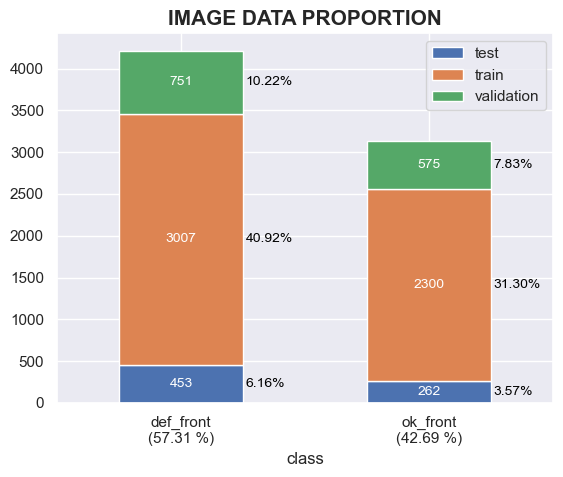

In [43]:
total_image = data_crosstab.iloc[-1,-1]
ax = data_crosstab.iloc[:-1,:-1].T.plot(kind = "bar", stacked = True, rot = 0)

percent_val = []

for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    percent = 100*height/total_image

    ax.text(rect.get_x() + width - 0.25, 
            rect.get_y() + height/2, 
            int(height), 
            ha = 'center',
            va = 'center',
            color = "white",
            fontsize = 10)
    
    ax.text(rect.get_x() + width + 0.01, 
            rect.get_y() + height/2, 
            "{:.2f}%".format(percent), 
            ha = 'left',
            va = 'center',
            color = "black",
            fontsize = 10)
    
    percent_val.append(percent)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)

percent_def = sum(percent_val[::2])
ax.set_xticklabels(["def_front\n({:.2f} %)".format(percent_def), "ok_front\n({:.2f} %)".format(100-percent_def)])
plt.title("IMAGE DATA PROPORTION", fontsize = 15, fontweight = "bold")
plt.show()

In [44]:
mapping_class = {0: "ok", 1: "defect"}
mapping_class

{0: 'ok', 1: 'defect'}

In [45]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

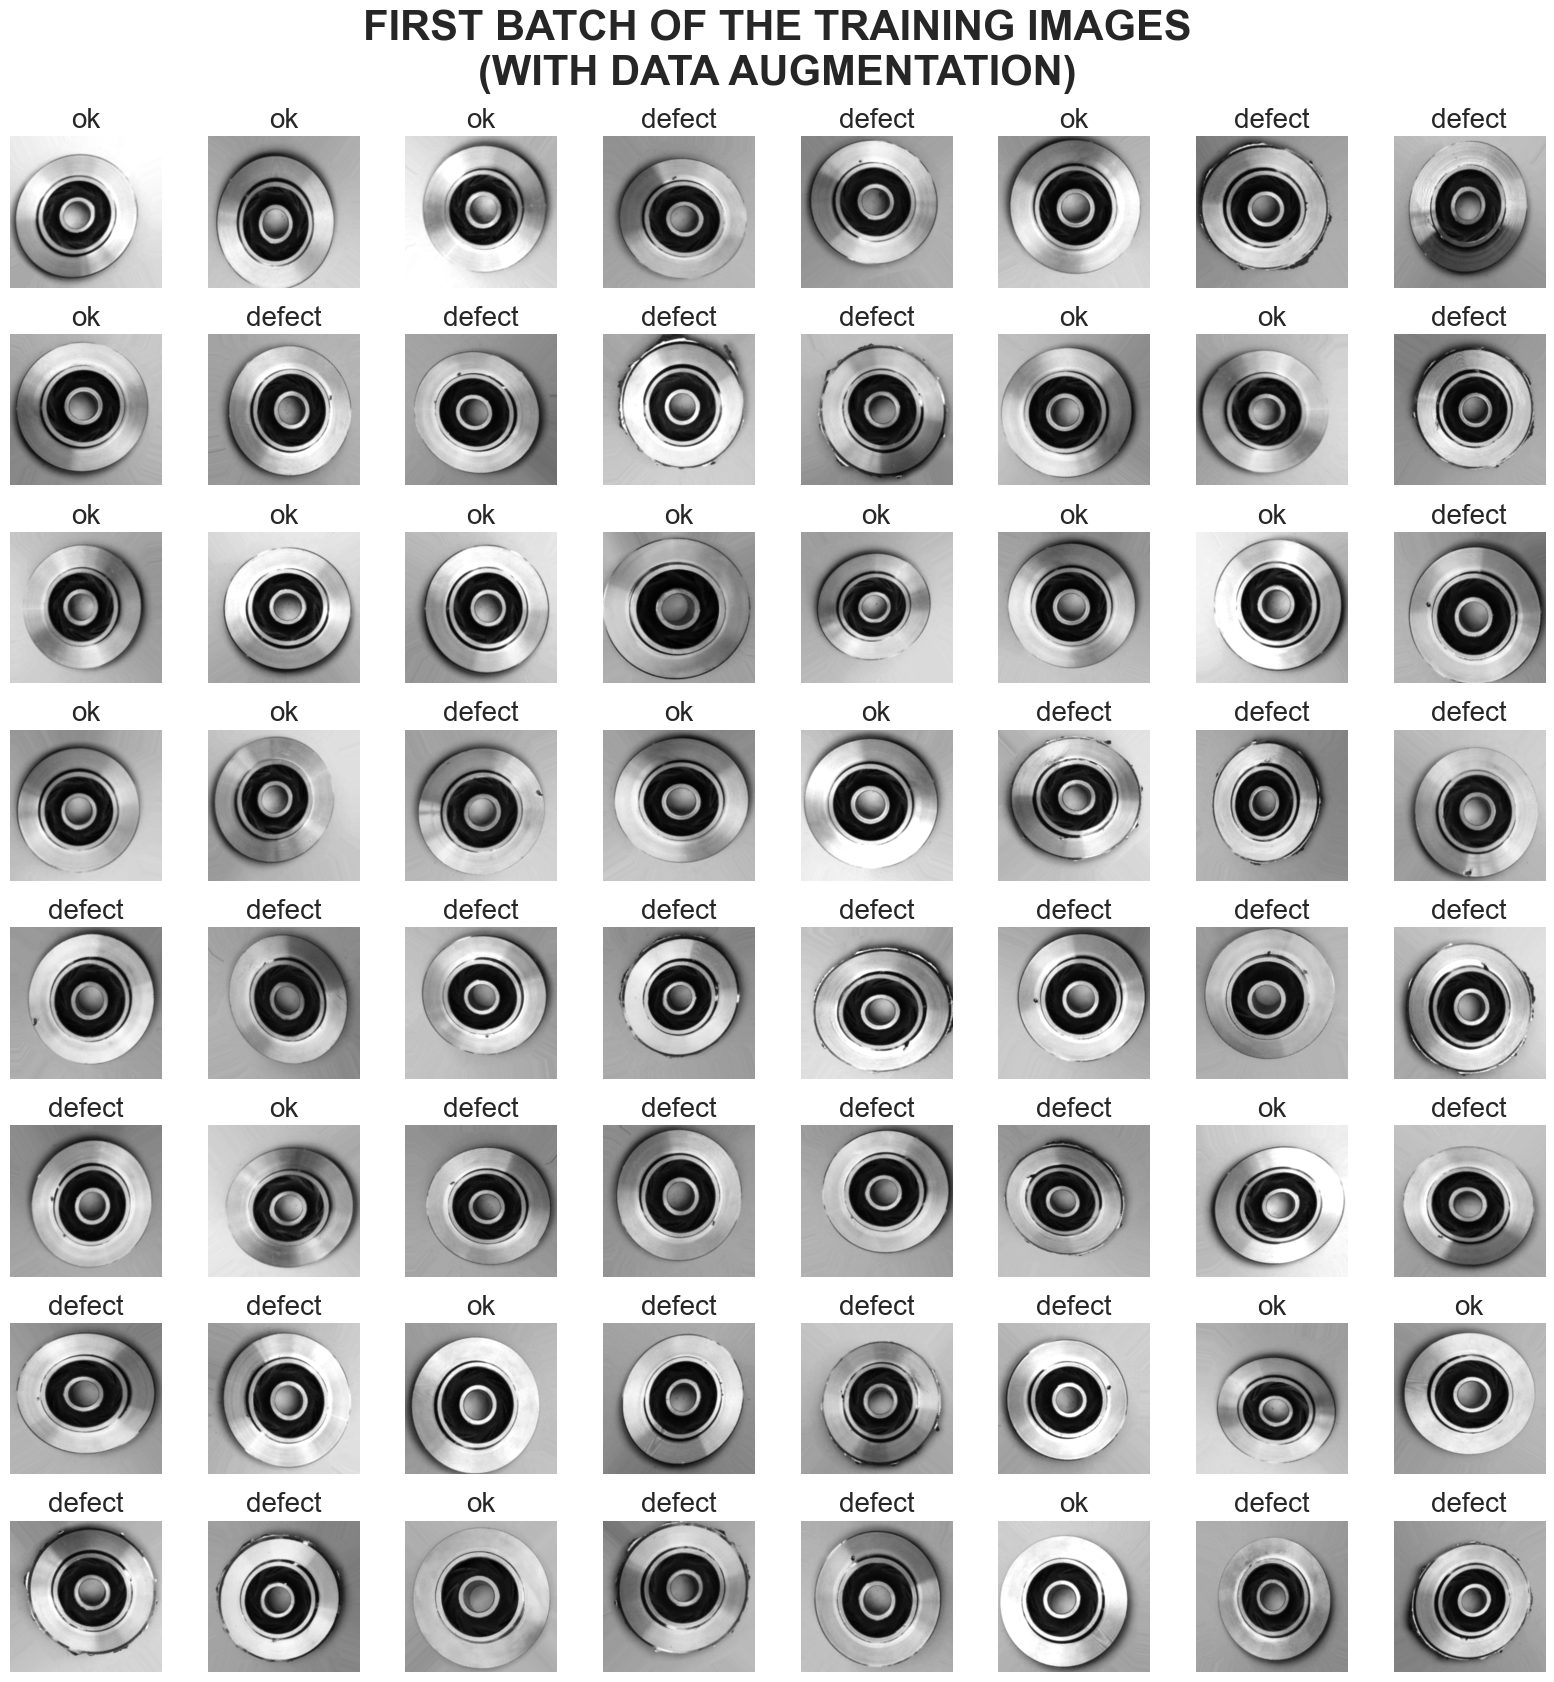

In [48]:
train_images = visualizeImageBatch(train_dataset,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

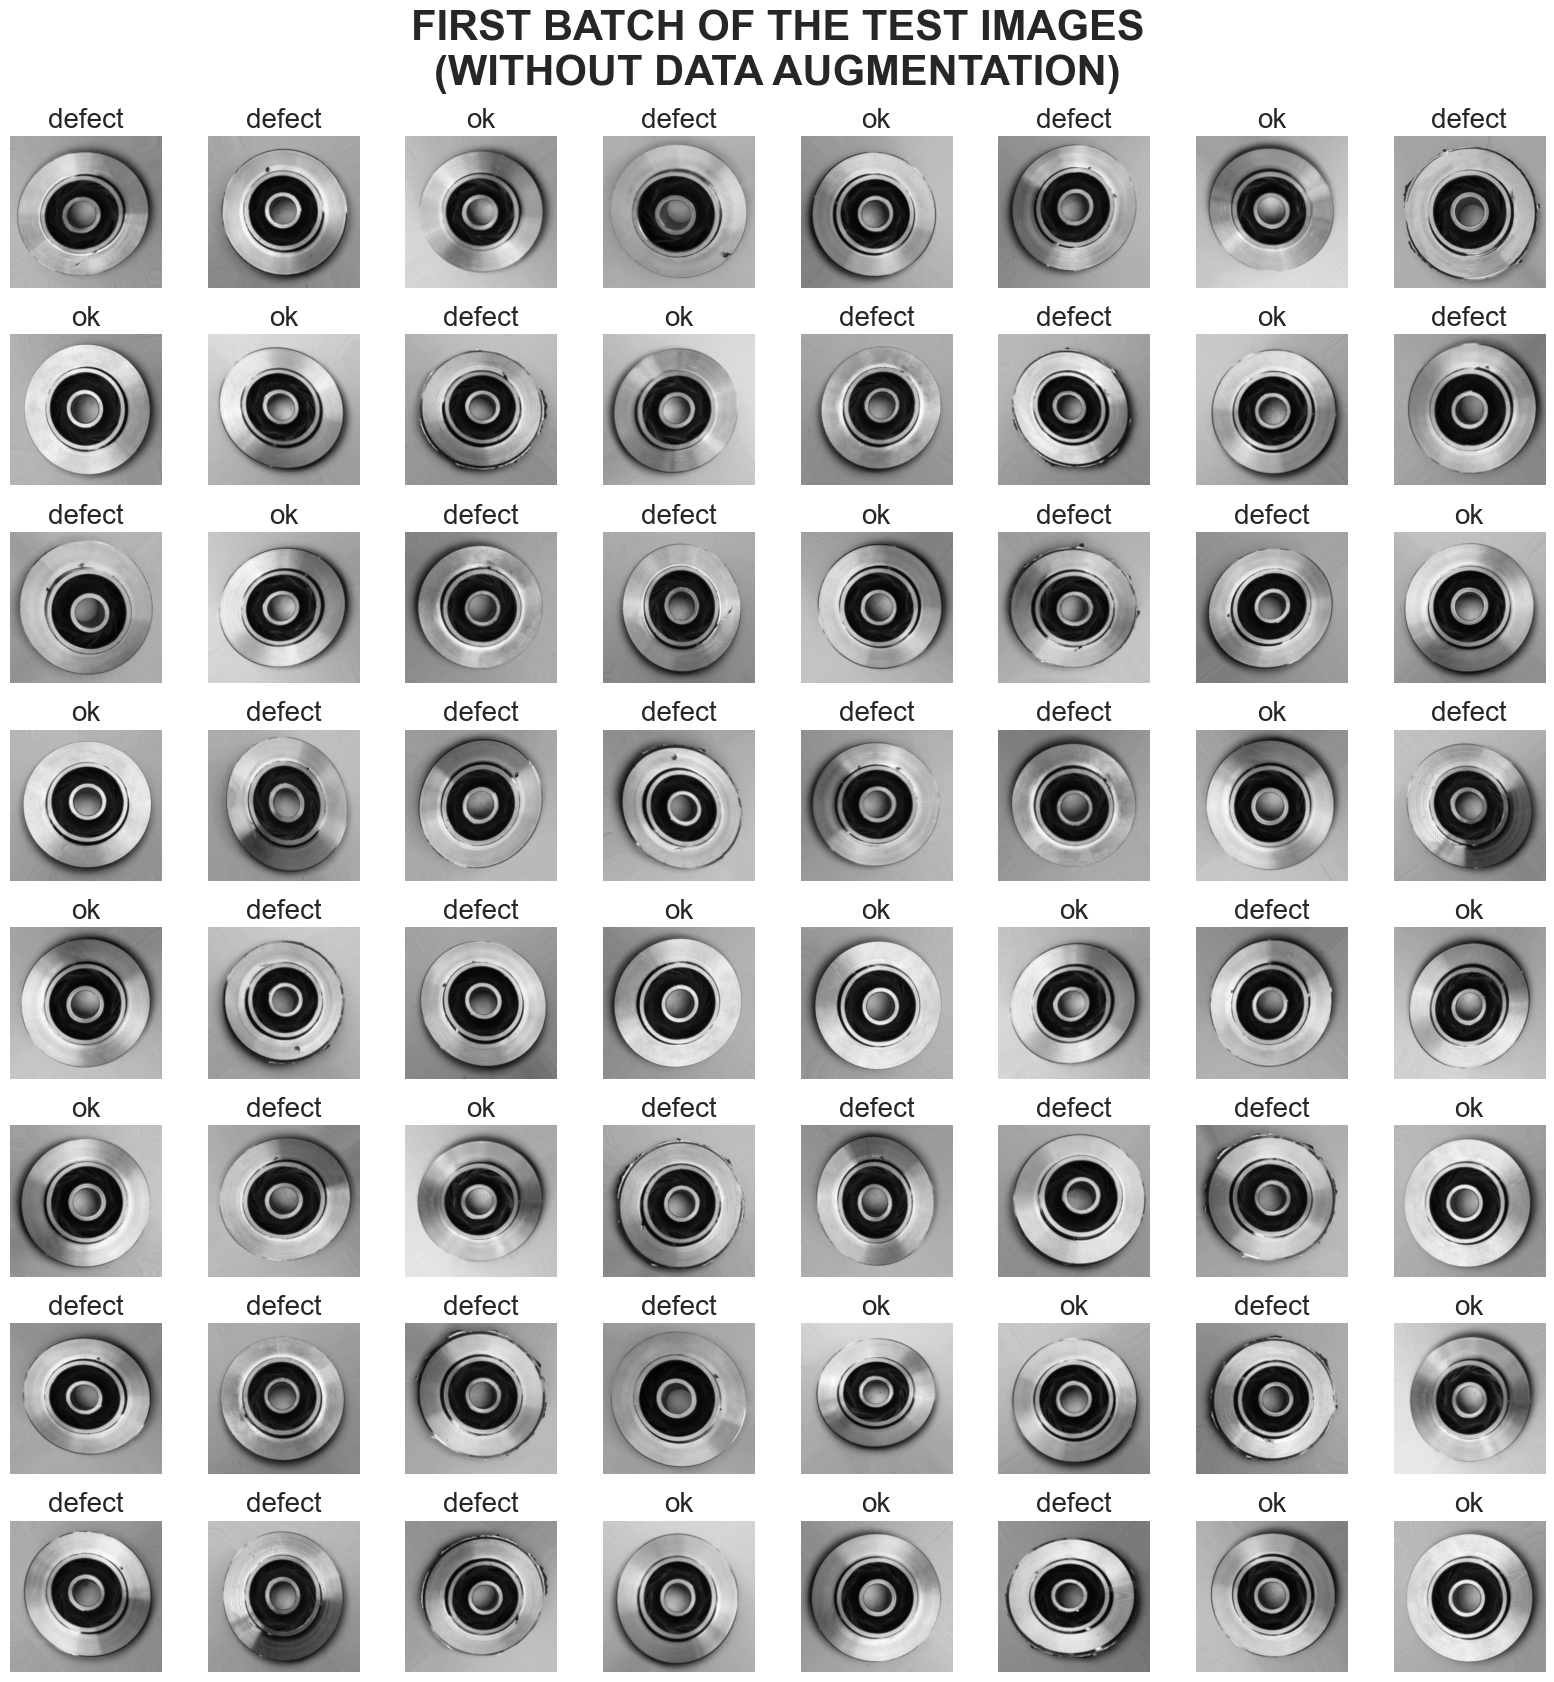

In [49]:
test_images = visualizeImageBatch(test_dataset,
                                  "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")

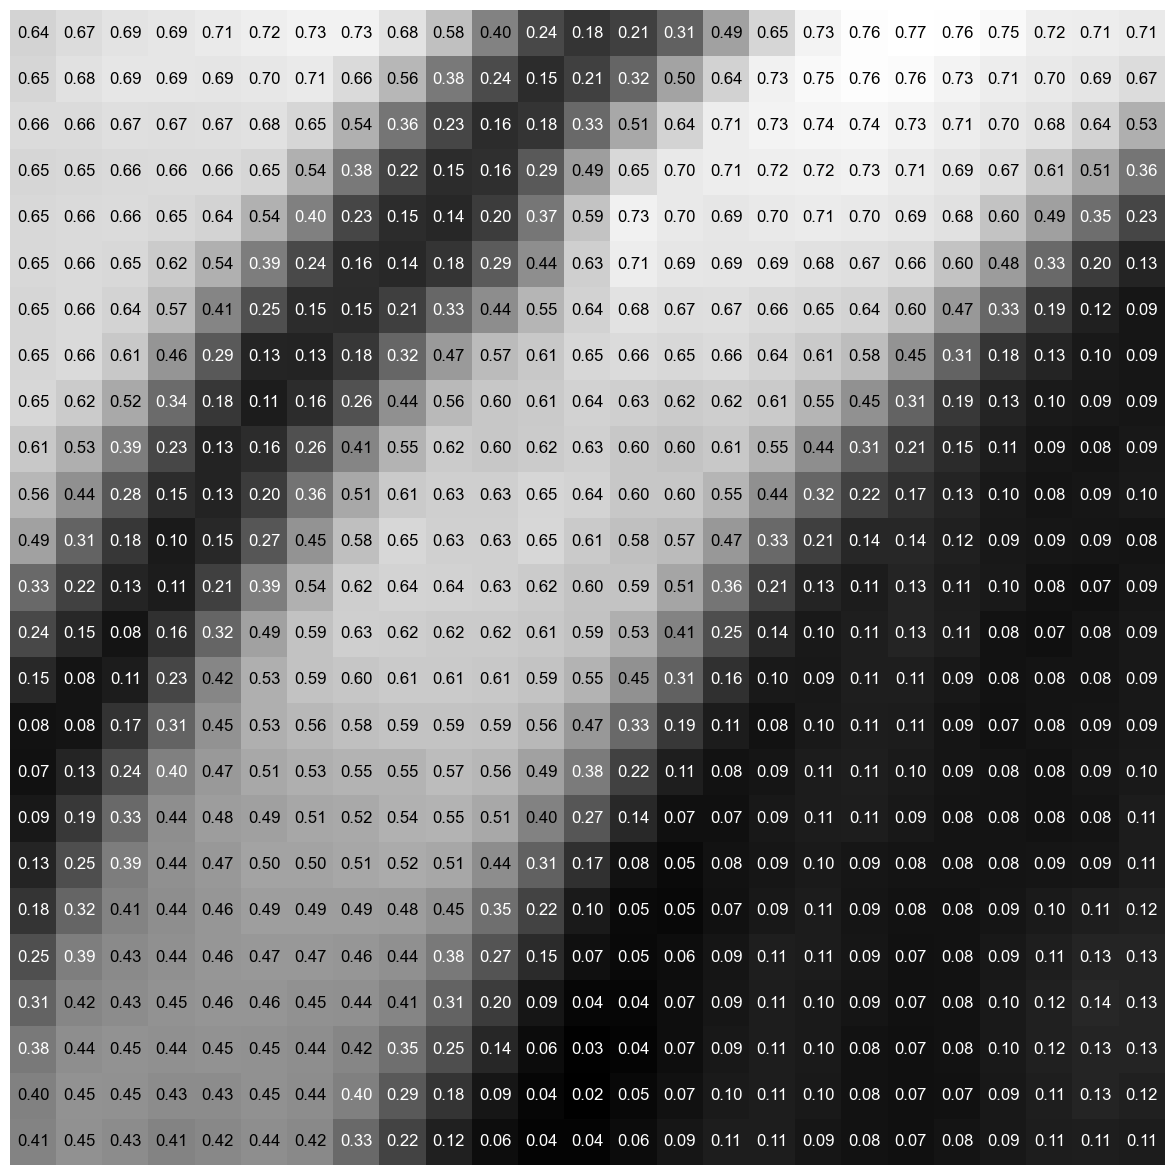

In [50]:
img = np.squeeze(train_images[4])[75:100, 75:100]

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = "gray")
ax.axis("off")

w, h = img.shape
for x in range(w):
    for y in range(h):
        value = img[x][y]
        ax.annotate("{:.2f}".format(value), xy = (y,x),
                    horizontalalignment = "center",
                    verticalalignment = "center",
                    color = "white" if value < 0.4 else "black")

In [51]:
model = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 149, 149, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 128)               6

In [52]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [53]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5571015161725252328
xla_global_id: -1
]


In [63]:
STEPS = 50

checkpoint = ModelCheckpoint("cnn_casting_inspection_model.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model.fit(train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = STEPS,
                    epochs = 5,
                    validation_steps = STEPS,
                    callbacks = [checkpoint],
                    verbose = 1)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.7538WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 0.40196, saving model to cnn_casting_inspection_model.hdf5
50/50 [==============================] - 70s 1s/step - loss: 0.4762 - accuracy: 0.7538 - val_loss: 0.4020 - val_accuracy: 0.8084
Epoch 2/5
50/50 [==============================] - 52s 1s/step - loss: 0.4185 - accuracy: 0.7944
Epoch 3/5
50/50 [==============================] - 52s 1s/step - loss: 0.3712 - accuracy: 0.8288
Epoch 4/5
50/50 [==============================] - 52s 1s/step - loss: 0.3230 - accuracy: 0.8516
Epoch 5/5
50/50 [==============================] - 54s 1s/step - loss: 0.2711 - accuracy: 0.8823


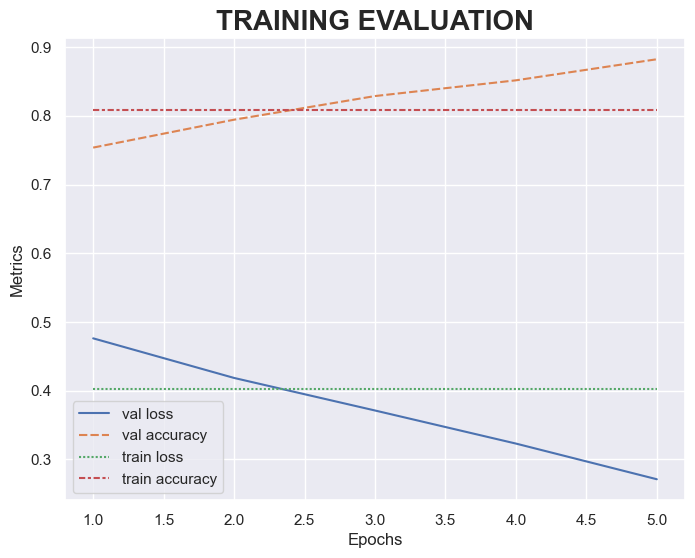

In [64]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [65]:
best_model = load_model("cnn_casting_inspection_model.hdf5")

In [66]:
y_pred_prob = best_model.predict_generator(generator = test_dataset,
                                           verbose = 1)

C:\Users\skkam\AppData\Local\Temp\ipykernel_10824\3597982824.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = best_model.predict_generator(generator = test_dataset,


12/12 [==============================] - 3s 256ms/step


In [67]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

Predicted       
                     ok defect
Actual ok           142    120
       defect       230    223

In [68]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.3817    0.5420    0.4479       262
           1     0.6501    0.4923    0.5603       453

    accuracy                         0.5105       715
   macro avg     0.5159    0.5171    0.5041       715
weighted avg     0.5518    0.5105    0.5191       715



1/1 [==============================] - 0s 32ms/step


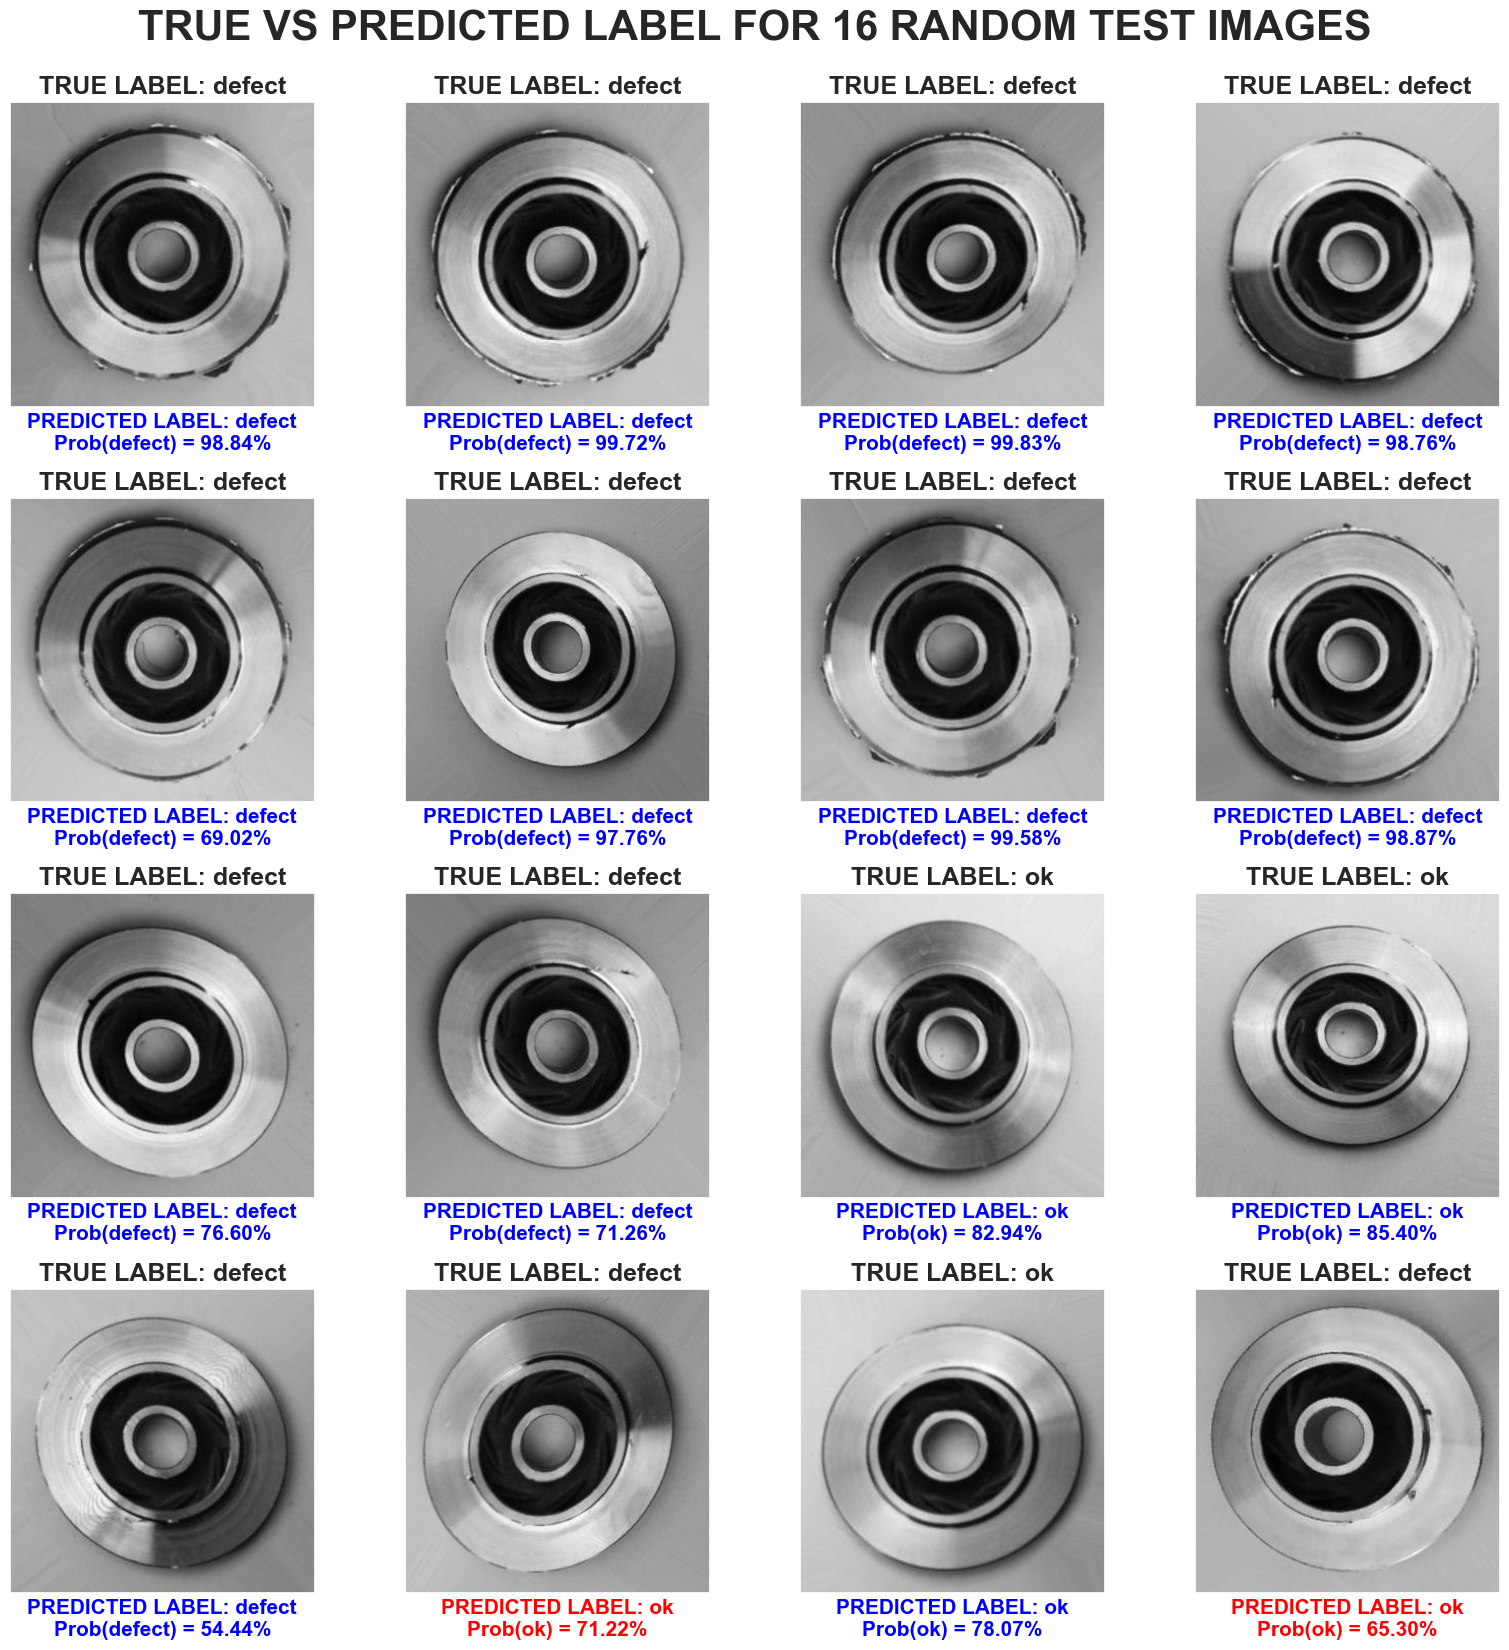

In [70]:
images, labels = next(iter(test_dataset))
images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap = "gray")
    true_label = mapping_class[label]
    
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("TRUE VS PREDICTED LABEL FOR 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

1/1 [==============================] - 0s 41ms/step


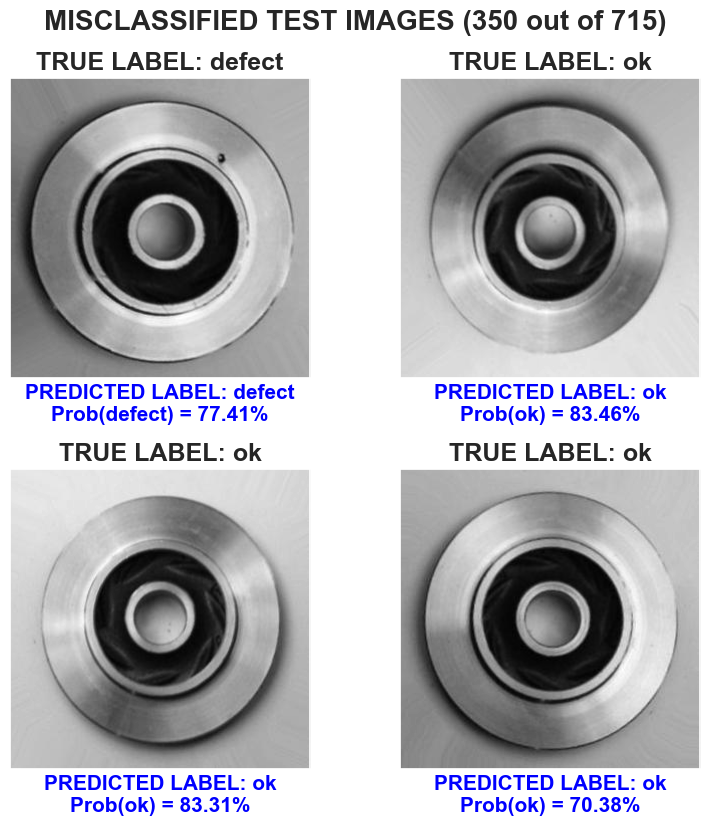

In [71]:
misclassify_pred = np.nonzero(y_pred_class != y_true_class)[0]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // BATCH_SIZE, misclassify_pred % BATCH_SIZE):
    images, labels = test_dataset[batch_num]
    img = images[image_num]
    ax.imshow(img.reshape(*IMAGE_SIZE), cmap = "gray")
    
    true_label = mapping_class[labels[image_num]]
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle(f"MISCLASSIFIED TEST IMAGES ({len(misclassify_pred)} out of {len(y_true_class)})",
             size = 20, y = 1.03, fontweight = "bold")
plt.show()